In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
print(torch.cuda.is_available())

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002
TRAINDATA = "ISIC/ISIC-2017_Training_Data"
TESTDATA = "ISIC/ISIC-2017_Test_v2_Data"
NUM_EPOCHS = 1
BATCH_SIZE = 128

FEATURES_DISC = 64
FEATURES_GEN = 64
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100

#size of images
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

Device: cuda:0
True


In [243]:
#Initialise the datasets and load the data. 


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CelebA(root='data',
                                split='train',
                                transform=custom_transforms,
                                download=True)

valid_dataset = datasets.CelebA(root='data',
                                split='valid',
                                transform=custom_transforms)

test_dataset = datasets.CelebA(root='data',
                                split='test',
                                transform=custom_transforms)


train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=True)

valid_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            num_workers=4,
                            shuffle=False)

Files already downloaded and verified


<head> Verification and Printing data

Training Set:

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128, 40])

Validation Set:
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128, 40])

Testing Set:
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128, 40])


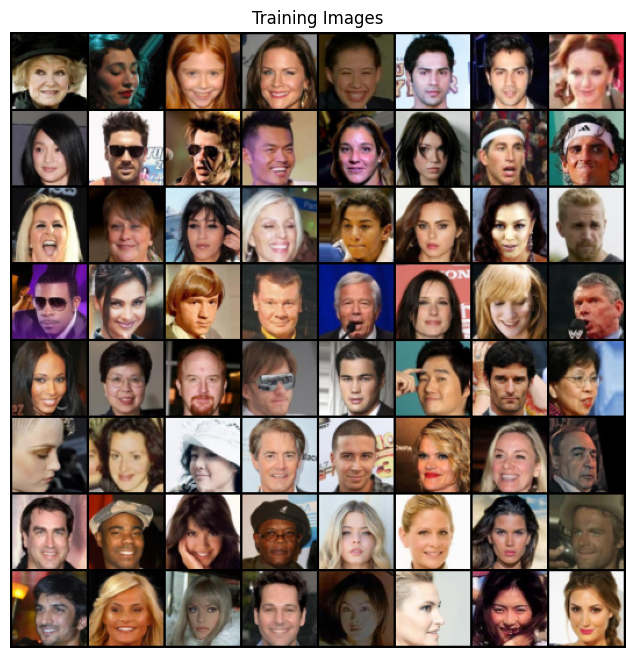

In [ ]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

<head> This is discrimination and generator. 

<heading1> Generator <heading1/>

In [ ]:
##########################
### MODEL
##########################

class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
        super().__init__()
        
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #              
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #   
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #   
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            nn.Flatten(),
            
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [ ]:

model = DCGAN()
model.to(DEVICE)

optimiser_gen = torch.optim.SGD(model.generator.parameters(),
                             lr=GENERATOR_LEARNING_RATE)

optimiser_discr = torch.optim.SGD(model.discriminator.parameters(),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [ ]:

log_dict = {'train_generator_loss_per_batch': [],
            'train_discriminator_loss_per_batch': [],
            'train_discriminator_real_acc_per_batch': [],
            'train_discriminator_fake_acc_per_batch': [],
            'images_from_noise_per_epoch': []}

loss_fn = F.binary_cross_entropy_with_logits

# Batch of latent (noise) vectors for
# evaluating / visualizing the training progress
# of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=DEVICE) # format NCHW
save_model = None
start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, _) in enumerate(train_loader):
        batch_size = features.size(0)
        # real images
        real_images = features.to(DEVICE)
        real_labels = torch.ones(batch_size, device=DEVICE) # real label = 1

        # generated (fake) images
        noise = torch.randn(batch_size, 100, 1, 1, device=DEVICE)  # format NCHW
        fake_images = model.generator_forward(noise)
        fake_labels = torch.zeros(batch_size, device=DEVICE) # fake label = 0
        flipped_fake_labels = real_labels # here, fake label = 1

        # --------------------------
        # Train Discriminator
        # --------------------------

        optimiser_discr.zero_grad()

        # get discriminator loss on real images
        discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
        real_loss = loss_fn(discr_pred_real, real_labels)
        # real_loss.backward()

        # get discriminator loss on fake images
        discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss = loss_fn(discr_pred_fake, fake_labels)
        # fake_loss.backward()

        # combined loss
        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()

        optimiser_discr.step()

        # --------------------------
        # Train Generator
        # --------------------------

        optimiser_gen.zero_grad()

        # get discriminator loss on fake images with flipped labels
        discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
        gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
        gener_loss.backward()

        optimiser_gen.step()

        # --------------------------
        # Logging
        # --------------------------   
        log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
        log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
        
        predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
        predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
        acc_real = (predicted_labels_real == real_labels).float().mean()*100.
        acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
        log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
        log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
        
        if not batch_idx % 100:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                    % (epoch+1, NUM_EPOCHS, batch_idx, 
                        len(train_loader), gener_loss.item(), discr_loss.item()))

    ### Save images for evaluation
    with torch.no_grad():
        fake_images = model.generator_forward(fixed_noise).detach().cpu()
        log_dict['images_from_noise_per_epoch'].append(
            torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

if save_model is not None:
    torch.save(model.state_dict(), save_model)



Epoch: 001/001 | Batch 000/1272 | Gen/Dis Loss: 0.8203/0.7559


KeyboardInterrupt: 